In [ ]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

base_quantization = os.path.abspath('/home/samuel-rivera/Development/ECE661/research_project/Base-quantization') 
sys.path.insert(0, base_quantization) 

# Importing quantization utilities from Base-quantization
# Import the specific modules that exist in the directory
import quantization  # This imports the quantization package
import utils  # This imports utils.py
import torchvision

# palette
wine    = "#7a1e3a"   # dark red wine
navy    = "#1f3a93"   # navy blue
grey    = "#8a9099"   # grey
mustard = "#d4a72c"   # mustard yellow

theme = {
    # backgrounds
    "figure.facecolor": "#ffffff",
    "axes.facecolor":   "#ffffff",
    "savefig.facecolor":"#ffffff",

    # text and ticks
    "axes.edgecolor":   "#0f172a",
    "axes.labelcolor":  "#0f172a",
    "xtick.color":      "#0f172a",
    "ytick.color":      "#0f172a",
    "text.color":       "#0f172a",

    # white grid
    "axes.grid": True,
    "axes.grid.axis": "both",
    "axes.grid.which": "major",
    "grid.color": "#ffffff",
    "grid.alpha": 0.18,
    "grid.linestyle": ":",
    "grid.linewidth": 1.0,

    # series colors
    "axes.prop_cycle": cycler("color", [wine, navy, grey, mustard]),

    # general look
    "font.size": 12,
    "lines.linewidth": 2.0,
    "legend.frameon": False,
    "axes.titlepad": 8,
    "axes.titleweight": "semibold",
}

mpl.rcParams.update(theme)
plt.rcParams.update({'figure.dpi': 300,
                     'font.size': 12,
                     })

# Disabling gradients for evaluation
torch.no_grad()

# Load checkpoints
checkpoint_fp32 = torch.load('/home/samuel-rivera/Development/ECE661/research_project/Base-quantization/checkpoint/ResNet18/resnet18_fp32.pth')
checkpoint_q = torch.load('/home/samuel-rivera/Development/ECE661/research_project/Base-quantization/checkpoint/ResNet18/resnet18_q_8.pth')

# Create FP32 model
model = torchvision.models.resnet18(weights=None, num_classes=10)
model.load_state_dict(utils.add_module_dict(checkpoint_fp32['net']))
model.eval()

# Create quantized model - need to replicate the quantization process
# This creates the same architecture as was used during quantization
qmodel = torchvision.models.resnet18(weights=None, num_classes=10)
# Apply quantization layers (this transforms the architecture)
qmodel = utils.inplace_quantize_layers(
    qmodel,
    total_steps=1,  # doesn't matter for inference
    ptq=True,
    dorefa=False,
    Histogram=False,
    level='L',  # per-layer quantization
    omse=False,
    adaround=False,
    bias_correction=False,
    lsq=False,
    bit=8  # 8-bit quantization
)
# Now load the quantized weights
qmodel.load_state_dict(utils.add_module_dict(checkpoint_q['net']), strict=False)
qmodel.eval()

print("Loaded models:")
print(f"  Full precision model: ResNet18 (FP32)")
print(f"    - Accuracy: {checkpoint_fp32['acc']:.2f}%")
print(f"    - Epoch: {checkpoint_fp32['epoch']}")
print(f"  Quantized model: ResNet18 (8-bit)")
print(f"    - Accuracy: {checkpoint_q['acc']:.2f}%")
print(f"    - Epoch: {checkpoint_q['epoch']}")

def get_all_linear_layers(model):
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Linear, quantization.QLinear)):
            layers.append((name, module))
    return layers

def get_all_conv_layers(model):
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, quantization.QConv2d, quantization.QConv2dBn)):
            layers.append((name, module))
    return layers

def get_all_bn_layers(model):
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            layers.append((name, module))
    return layers

def get_all_quantizable_layers(model):
    """Get all layers that can be quantized (Conv2d, Linear, BatchNorm2d)
    Also includes quantized versions (QConv2d, QConv2dBn, QLinear)"""
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.BatchNorm2d,
                              quantization.QConv2d, quantization.QConv2dBn, quantization.QLinear)):
            layers.append((name, module))
    return layers

# Convert layer names to readable format
# "layer1.0.conv1" => "layer1.0.conv1"
# "model.decoder.layers.3.self_attn.q_proj" => "3.q_proj" (for transformer models)
def nice_name(name):
    parts = name.split(".")

    # For transformer models (OPT, etc.)
    num = None
    role = None
    for p in parts:
        if p.isdigit():
            num = p
        if p in ["q_proj", "k_proj", "v_proj", "fc1", "fc2", "out_proj"]:
            role = p
    if num is not None and role is not None:
        return f"{num}.{role}"

    # For ResNet-like models, keep the full layer path or simplify
    # Example: "layer1.0.conv1" or "fc"
    if "layer" in name or "downsample" in name or name in ["conv1", "fc"]:
        return name

    return name

def get_layer_type(module):
    """Return a readable layer type name"""
    if isinstance(module, (torch.nn.Conv2d, quantization.QConv2d, quantization.QConv2dBn)):
        return "Conv2d"
    elif isinstance(module, (torch.nn.Linear, quantization.QLinear)):
        return "Linear"
    elif isinstance(module, torch.nn.BatchNorm2d):
        return "BatchNorm2d"
    else:
        return type(module).__name__

cpu
Loaded models:
  Full precision model: ResNet18 (FP32)
    - Accuracy: 88.18%
    - Epoch: 175
  Quantized model: ResNet18 (8-bit)
    - Accuracy: 80.72%
    - Epoch: 0


Found 21 Conv2d+Linear layers in FP32 model
Found 21 Conv2d+Linear layers in quantized model
Computed MSE for 21 layers



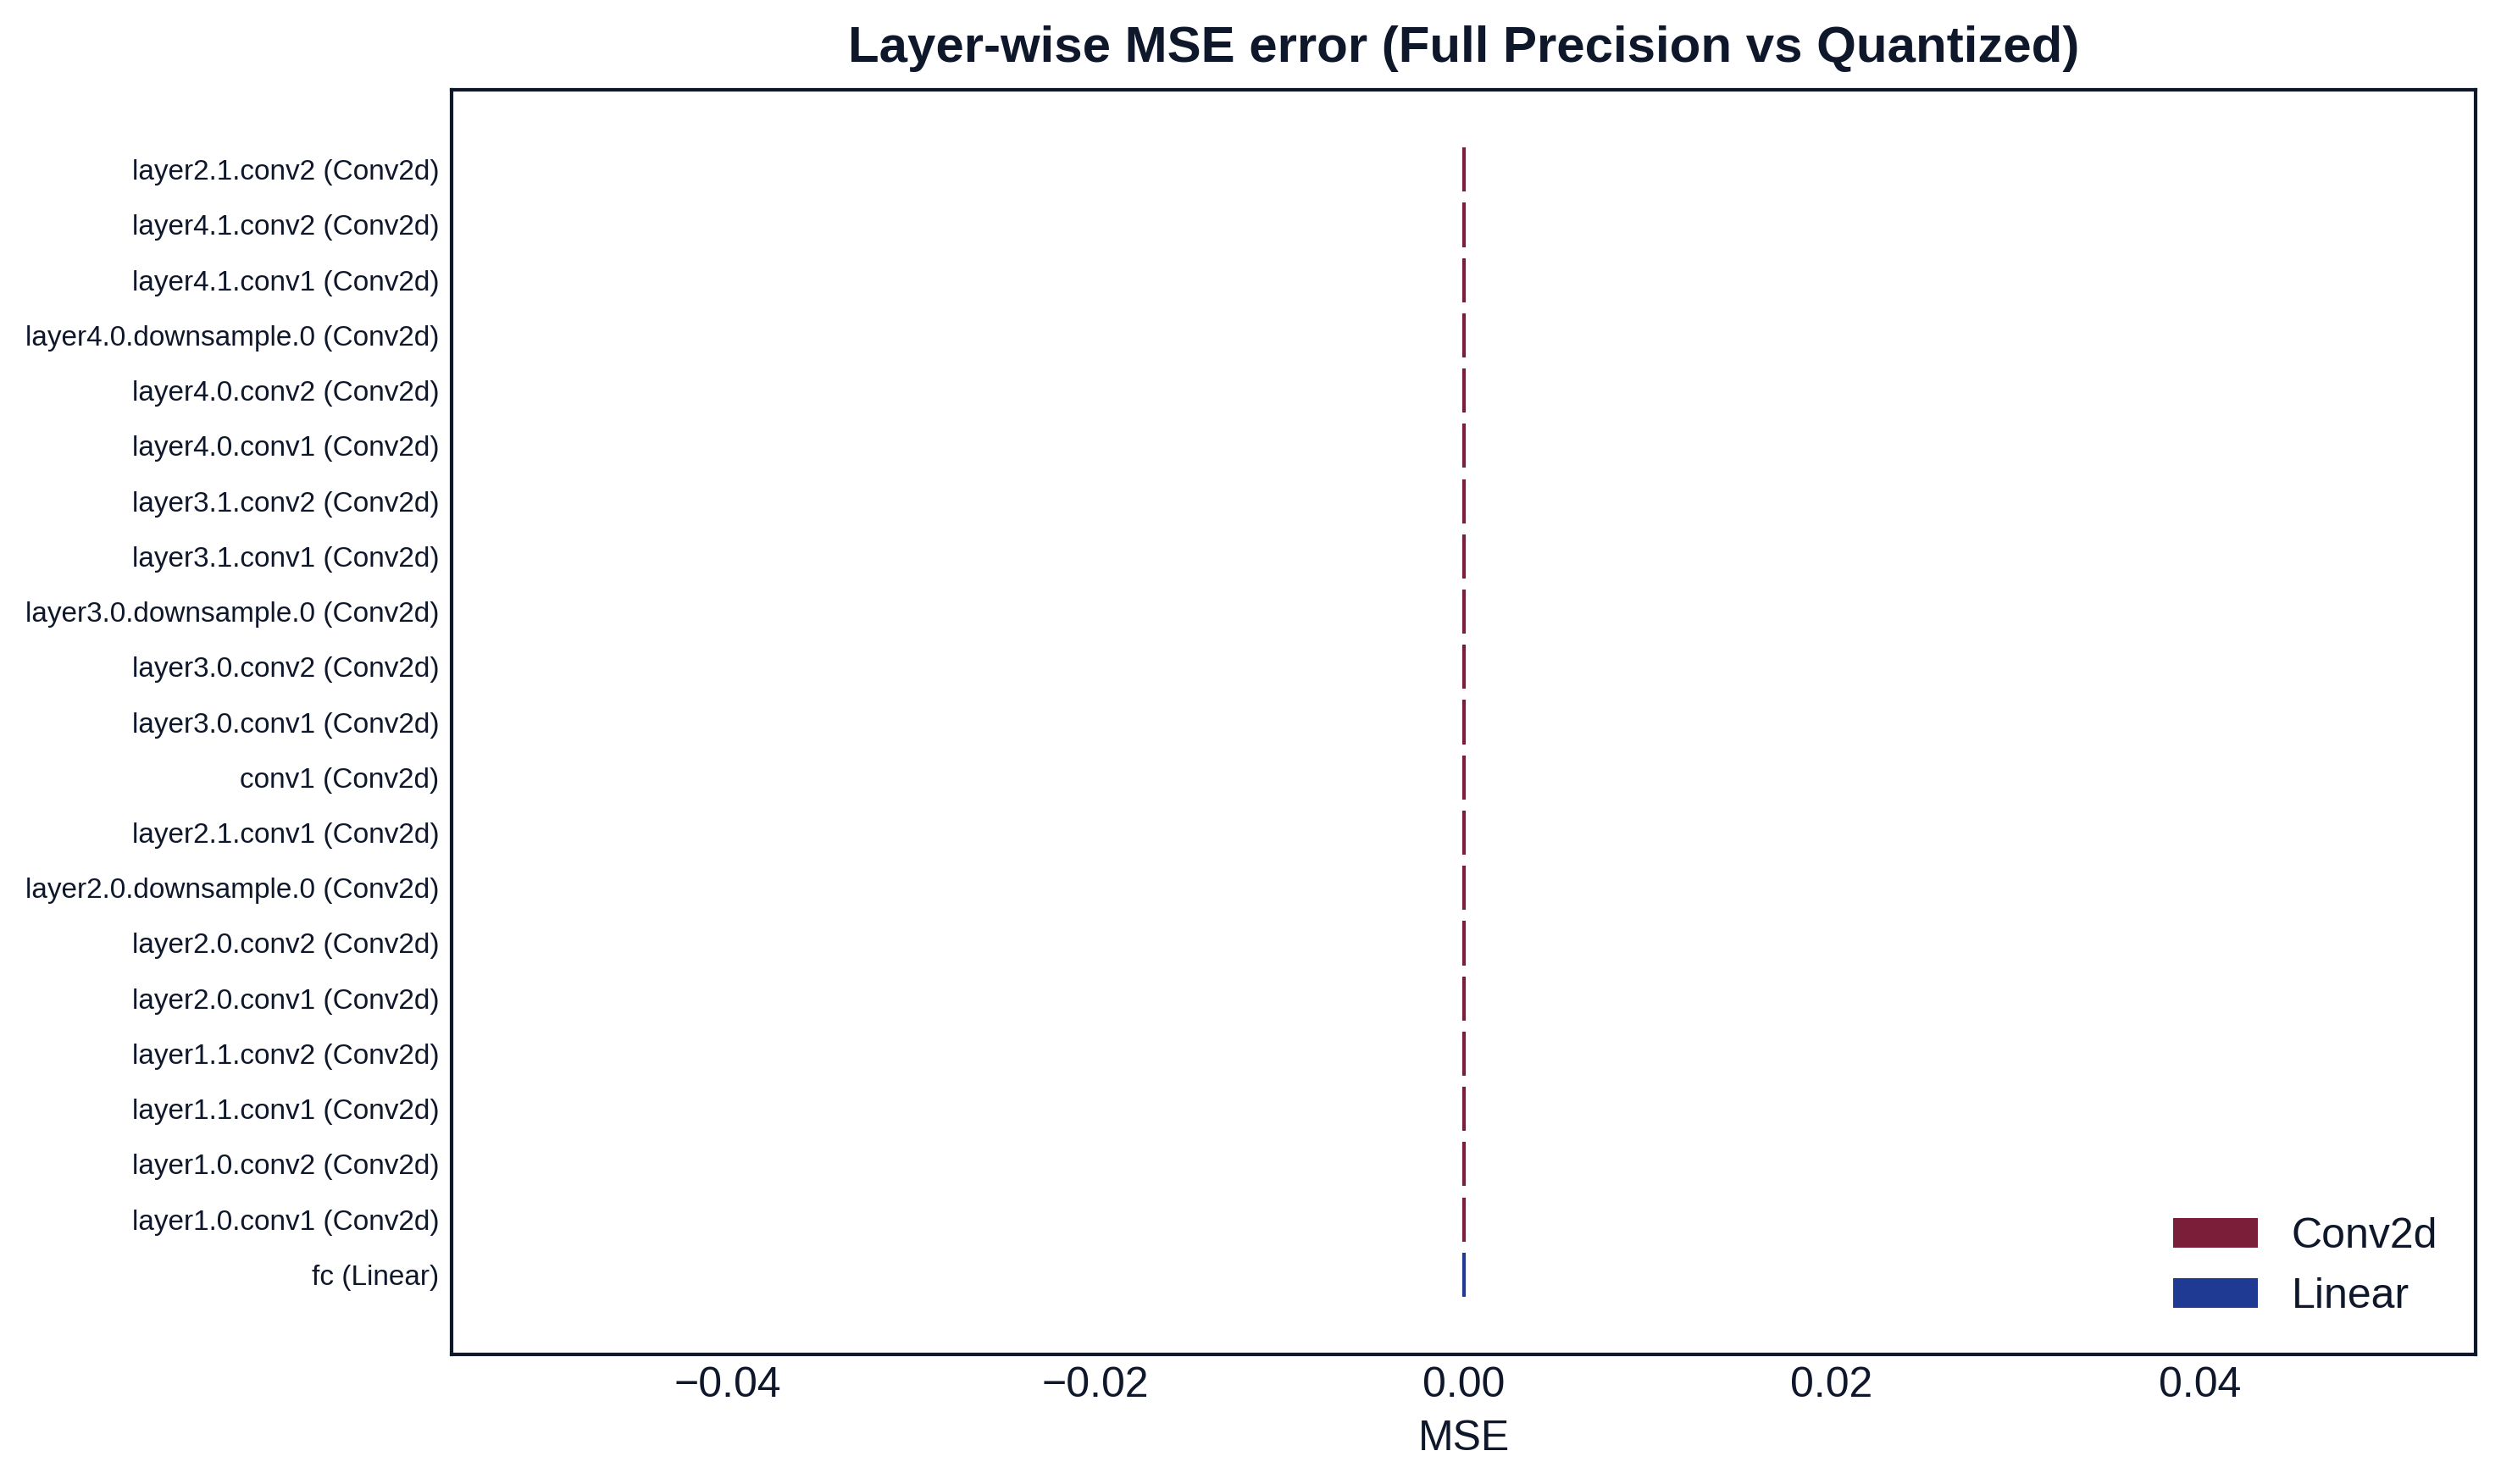


MSE Statistics:
  Min: 0.000000e+00
  Max: 0.000000e+00
  Mean: 0.000000e+00


In [17]:
# compute metrics - works with Conv2d and Linear layers
abs_err = []
sn_err = []
names = []
layer_types = []

# For quantized models, only compare Conv2d and Linear layers
# (BatchNorm gets fused into Conv layers during quantization)
org_layers = get_all_conv_layers(model) + get_all_linear_layers(model)
q_layers = get_all_conv_layers(qmodel) + get_all_linear_layers(qmodel)

print(f"Found {len(org_layers)} Conv2d+Linear layers in FP32 model")
print(f"Found {len(q_layers)} Conv2d+Linear layers in quantized model")

# Sort by name to ensure matching
org_layers = sorted(org_layers, key=lambda x: x[0])
q_layers = sorted(q_layers, key=lambda x: x[0])

assert len(org_layers) == len(q_layers), f"Layer count mismatch: {len(org_layers)} vs {len(q_layers)}"

for (name_org, layer_org), (name_q, layer_q) in zip(org_layers, q_layers):
    # Get weights
    W_org = layer_org.weight.data.float()
    W_q = layer_q.weight.data.float()

    mse = torch.mean((W_org - W_q) ** 2).item()  # absolute error

    names.append(nice_name(name_org))
    layer_types.append(get_layer_type(layer_org))
    abs_err.append(mse)

print(f"Computed MSE for {len(abs_err)} layers\n")

# choose ordering once so the two plots line up
order = torch.tensor(abs_err).argsort(descending=True).tolist()

ordered_names = [names[i] for i in order]
ordered_abs = [abs_err[i] for i in order]
ordered_types = [layer_types[i] for i in order]

# optionally focus on top K to keep labels readable
top_k = 40
ordered_names = ordered_names[:top_k]
ordered_abs = ordered_abs[:top_k]
ordered_types = ordered_types[:top_k]

# absolute error chart
plt.figure(figsize=(10, max(6, len(ordered_names) * 0.25)))
bars = plt.barh(range(len(ordered_abs)), ordered_abs)

# Color bars by layer type
type_colors = {"Conv2d": wine, "Linear": navy, "BatchNorm2d": grey}
for i, (bar, ltype) in enumerate(zip(bars, ordered_types)):
    bar.set_color(type_colors.get(ltype, mustard))

# Add layer type to labels
labels = [f"{name} ({ltype})" for name, ltype in zip(ordered_names, ordered_types)]
plt.yticks(range(len(labels)), labels, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("MSE")
plt.title("Layer-wise MSE error (Full Precision vs Quantized)")
plt.grid(axis="x", linestyle=":", linewidth=0.7)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=ltype) 
                  for ltype, color in type_colors.items() if ltype in ordered_types]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nMSE Statistics:")
print(f"  Min: {min(abs_err):.6e}")
print(f"  Max: {max(abs_err):.6e}")
print(f"  Mean: {sum(abs_err)/len(abs_err):.6e}")

In [ ]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt

# Group by layer type for cross-architecture analysis
layer_type_groups = defaultdict(list)
sn_vals = defaultdict(list)

org_layers = get_all_conv_layers(model) + get_all_linear_layers(model)
q_layers = get_all_conv_layers(qmodel) + get_all_linear_layers(qmodel)

# Sort by name to ensure matching
org_layers = sorted(org_layers, key=lambda x: x[0])
q_layers = sorted(q_layers, key=lambda x: x[0])

for (name_org, layer_org), (name_q, layer_q) in zip(org_layers, q_layers):
    W_org = layer_org.weight.data.float()
    W_q = layer_q.weight.data.float()

    diff = W_org - W_q
    mse = torch.mean(diff * diff).item()

    denom = torch.sum(W_org * W_org).item()
    sn = mse / max(denom, 1e-12)

    # Group by layer type
    ltype = get_layer_type(layer_org)
    layer_type_groups[ltype].append(mse)
    sn_vals[ltype].append(sn)

# Compute per layer type averages for absolute error
role_means = {r: float(torch.tensor(v).mean()) for r, v in layer_type_groups.items() if len(v) > 0}

ordered_roles = sorted(role_means, key=lambda r: role_means[r], reverse=True)
ordered_vals = [role_means[r] for r in ordered_roles]

plt.figure(figsize=(8, 5))
bars = plt.barh(range(len(ordered_roles)), ordered_vals)

# Color bars by layer type
type_colors = {"Conv2d": wine, "Linear": navy, "BatchNorm2d": grey}
for i, (bar, ltype) in enumerate(zip(bars, ordered_roles)):
    bar.set_color(type_colors.get(ltype, mustard))

plt.yticks(range(len(ordered_roles)), ordered_roles, fontsize=12)
ax = plt.gca()
ax.invert_yaxis()

# Use scientific notation for small values
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.xlabel("MSE averaged across layers")
plt.title("Average MSE by layer type")
plt.grid(axis="x", linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

print("\nAbsolute MSE by layer type:")
for r in ordered_roles:
    print(f"{r:15s}  mean={role_means[r]:.6e}  count={len(layer_type_groups[r])}")

# Second metric: scale normalized error
sn_means = {r: float(torch.tensor(v).mean()) for r, v in sn_vals.items() if len(v) > 0}

ordered_roles_sn = sorted(sn_means, key=lambda r: sn_means[r], reverse=True)
ordered_vals_sn = [sn_means[r] for r in ordered_roles_sn]

plt.figure(figsize=(8, 5))
bars = plt.barh(range(len(ordered_roles_sn)), ordered_vals_sn)

# Color bars by layer type
for i, (bar, ltype) in enumerate(zip(bars, ordered_roles_sn)):
    bar.set_color(type_colors.get(ltype, mustard))

plt.yticks(range(len(ordered_roles_sn)), ordered_roles_sn, fontsize=12)
plt.gca().invert_yaxis()

# Use scientific notation
plt.gca().ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.xlabel("Normalized MSE averaged across layers")
plt.title("Average normalized MSE by layer type")
plt.grid(axis="x", linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

print("\nNormalized MSE by layer type:")
for r in ordered_roles_sn:
    print(f"{r:15s}  mean={sn_means[r]:.6e}  count={len(sn_vals[r])}")

In [ ]:
# Quantization level analysis (optional - shows effective bit-width)
q_layers = get_all_conv_layers(qmodel) + get_all_linear_layers(qmodel)

print("Quantization levels per layer:")
for name_q, layer_q in q_layers[:10]:  # Show first 10 only
    if not hasattr(layer_q, 'weight'):
        continue
    
    W_q = layer_q.weight.data
    unique_vals = torch.unique(W_q)
    print(f"{nice_name(name_q):30s}: {len(unique_vals):4d} unique values")